In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10,8)

In [ ]:
df = pd.read_excel('/content/Data.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    873 non-null    datetime64[ns]
 1   DMI     873 non-null    float64       
 2   NINO    873 non-null    float64       
 3   NOA     873 non-null    float64       
 4   PDO     873 non-null    float64       
 5   SOI     873 non-null    float64       
 6   TP      873 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 47.9 KB


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

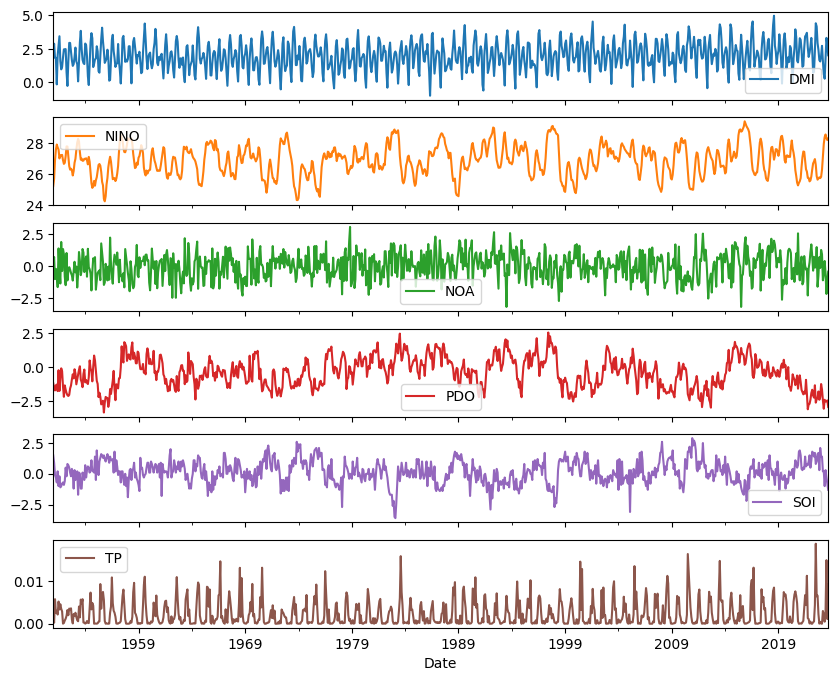

In [ ]:
df.set_index('Date')[['DMI','NINO','NOA','PDO','SOI','TP']].plot(subplots = True)

<ipython-input-5-7dc15b04bc5b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

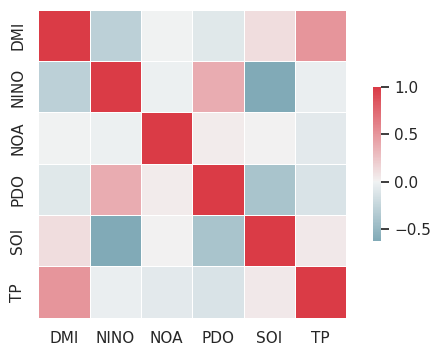

In [ ]:
import seaborn as sns
sns.set(style="white")
corr = df.corr()
f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
Correlation  = df.corr()['TP'].abs().sort_values(ascending=False)
Correlation

<ipython-input-6-1e9e7c1ce4a7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Correlation  = df.corr()['TP'].abs().sort_values(ascending=False)


TP      1.000000
DMI     0.502877
PDO     0.123481
NOA     0.077731
SOI     0.049904
NINO    0.033829
Name: TP, dtype: float64

In [ ]:
df_input = df[['TP','DMI','NINO','NOA','PDO','SOI']]

In [ ]:
df_input.describe()

,TP,DMI,NINO,NOA,PDO,SOI
count,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000
mean,0.002300,1.980122,26.907228,-0.003574,-0.411375,0.150859
std,0.003028,1.024755,0.979357,1.024611,1.109891,0.940867
min,0.000000,-0.994171,24.250000,-3.180000,-3.350000,-3.600000
25%,0.000128,1.306641,26.220000,-0.750000,-1.250000,-0.400000
50%,0.000822,1.958984,26.980000,0.050000,-0.380000,0.200000
75%,0.003605,2.707001,27.580000,0.720000,0.380000,0.800000
max,0.018763,4.969727,29.420000,3.040000,2.550000,2.900000


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.09819823, 0.53069464, 0.19148936, 0.52411576, 0.36610169,
        0.78461538],
       [0.0126527 , 0.65007548, 0.28239845, 0.62379421, 0.31016949,
        0.69230769],
       [0.3067056 , 0.47338877, 0.51257253, 0.34726688, 0.27627119,
        0.53846154],
       ...,
       [0.79434129, 0.72326468, 0.78723404, 0.16237942, 0.14067797,
        0.50769231],
       [0.05856244, 0.63253934, 0.76595745, 0.32475884, 0.15084746,
        0.43076923],
       [0.48520651, 0.50565178, 0.78529981, 0.44051447, 0.06949153,
        0.35384615]])

In [ ]:
features = data_scaled
target = data_scaled[:,0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
x_train.shape

(698, 6)

In [ ]:
x_test.shape

(175, 6)

In [ ]:
batch_size = 32
win_length = 60
num_features = 6
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()

# First LSTM layer with 128 units, LeakyReLU activation function
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

# Second LSTM layer with 128 units, LeakyReLU activation function
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

# Dropout layer with a rate of 0.3 to prevent overfitting
model.add(tf.keras.layers.Dropout (0.3))

# Add the third LSTM layer with 64 units and do not return sequences
model.add(tf.keras.layers.LSTM(64, return_sequences=False))

# Add another Dropout layer with a rate of 0.3
model.add(tf.keras.layers.Dropout (0.3))

# Add a Dense layer with 1 unit and no activation function
model.add(tf.keras.layers.Dense (1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           69120     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60, 128)           0         
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val loss',patience=2,mode= 'auto')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator,
                              epochs = 75,validation_data=test_generator,
                              shuffle=False, callbacks=[early_stopping])

Epoch 1/75


<ipython-input-18-70c2d31d56db>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.1219

20/20 [==============================] - 26s 599ms/step - loss: 0.0263 - mean_absolute_error: 0.1219 - val_loss: 0.0373 - val_mean_absolute_error: 0.1377
Epoch 2/75
20/20 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.1184

20/20 [==============================] - 4s 201ms/step - loss: 0.0247 - mean_absolute_error: 0.1184 - val_loss: 0.0357 - val_mean_absolute_error: 0.1512
Epoch 3/75
20/20 [==============================] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.1184

20/20 [==============================] - 5s 264ms/step - loss: 0.0245 - mean_absolute_error: 0.1184 - val_loss: 0.0350 - val_mean_absolute_error: 0.1465
Epoch 4/75
20/20 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.1160

20/20 [==============================] - 4s 219ms/step - loss: 0.0237 - mean_absolute_error: 0.1160 - val_loss: 0.0341 - val_mean_absolute_error: 0.1435
Epoch 5/75
20/20 [==============================] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.1140

20/20 [==============================] - 5s 227ms/step - loss: 0.0226 - mean_absolute_error: 0.1140 - val_loss: 0.0320 - val_mean_absolute_error: 0.1384
Epoch 6/75
20/20 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.1036

20/20 [==============================] - 4s 196ms/step - loss: 0.0193 - mean_absolute_error: 0.1036 - val_loss: 0.0255 - val_mean_absolute_error: 0.1131
Epoch 7/75
20/20 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0869

20/20 [==============================] - 5s 264ms/step - loss: 0.0152 - mean_absolute_error: 0.0869 - val_loss: 0.0219 - val_mean_absolute_error: 0.1034
Epoch 8/75
20/20 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0804

20/20 [==============================] - 4s 201ms/step - loss: 0.0131 - mean_absolute_error: 0.0804 - val_loss: 0.0202 - val_mean_absolute_error: 0.0977
Epoch 9/75
20/20 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0793

20/20 [==============================] - 5s 222ms/step - loss: 0.0127 - mean_absolute_error: 0.0793 - val_loss: 0.0190 - val_mean_absolute_error: 0.0935
Epoch 10/75
20/20 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0775

20/20 [==============================] - 4s 201ms/step - loss: 0.0123 - mean_absolute_error: 0.0775 - val_loss: 0.0199 - val_mean_absolute_error: 0.0894
Epoch 11/75
10/20 [==============>...............] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.0769

In [ ]:
model.evaluate_generator(test_generator, verbose=0)

In [ ]:
predictions = model.predict_generator(test_generator)

In [ ]:
predictions.shape[0]

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)

In [ ]:
df_pred

In [ ]:
rev_trans = scaler.inverse_transform(df_pred)

In [ ]:
df_final = df_input[predictions.shape[0]*-1:]

In [ ]:
df_final.count()

In [ ]:
df_final['TP_pred'] = rev_trans[:,0]

In [ ]:
df_final

In [ ]:
df_final[['TP','TP_pred']].plot(figsize=(8,4))

In [ ]:
rmse = np.sqrt(((df_final['TP_pred']-df_final['TP'])**2).mean())
rmse

In [ ]:
scaled_data = scaler.fit_transform(df_final[['TP_pred','TP']])

In [ ]:
scaled_rmse = np.sqrt(((scaled_data[:,0]-scaled_data[:,-1])**2).mean())
scaled_rmse